In [1]:
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings

warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")

In [2]:
df = pd.read_csv('final_data_10s.csv')

**Data Understanding:**

Let us first observe what the data types are first and ensure they are correct.
df.dtypes

Notice that the time column is an object which is not what we want, so lets convert this type to datetime type

In [3]:
df['Time'] = pd.to_datetime(df['Time'])
df.head()

,Time,X_BID,X_BID_VOL,X_ASK,X_ASK_VOL,Y_BID,Y_BID_VOL,Y_ASK,Y_ASK_VOL
0,2019-11-18 08:00:00,106340.0,15.0,106348.0,11.0,105200.0,9.0,105210.0,19.0
1,2019-11-18 08:00:10,106312.0,6.0,106320.0,9.0,105180.0,5.0,105190.0,13.0
2,2019-11-18 08:00:20,106312.0,7.0,106320.0,12.0,105170.0,32.0,105180.0,1.0
3,2019-11-18 08:00:30,106336.0,22.0,106340.0,1.0,105190.0,10.0,105200.0,19.0
4,2019-11-18 08:00:40,106352.0,2.0,106356.0,4.0,105200.0,29.0,105220.0,24.0


For sanity check, check whether there are null or empty values in columns.

In [4]:
df.isna().sum()

Time         0
X_BID        0
X_BID_VOL    0
X_ASK        0
X_ASK_VOL    0
Y_BID        0
Y_BID_VOL    0
Y_ASK        0
Y_ASK_VOL    0
dtype: int64

In [5]:
bad_x = df[df['X_ASK'] <= df['X_BID']]

print(f"Number of X crossed/zero markets: {len(bad_x)}")
bad_x.head()

Number of X crossed/zero markets: 174


,Time,X_BID,X_BID_VOL,X_ASK,X_ASK_VOL,Y_BID,Y_BID_VOL,Y_ASK,Y_ASK_VOL
496271,2020-08-19 11:00:00,101132.0,5.0,101132.0,16.0,103100.0,5.0,103640.0,6.0
496272,2020-08-19 11:00:10,101132.0,5.0,101132.0,16.0,103100.0,5.0,103640.0,6.0
496273,2020-08-19 11:00:20,101132.0,5.0,101132.0,16.0,103100.0,5.0,103640.0,6.0
496274,2020-08-19 11:00:30,101132.0,5.0,101132.0,16.0,103100.0,5.0,103640.0,6.0
496275,2020-08-19 11:00:40,100616.0,18.0,100616.0,26.0,103370.0,3.0,103370.0,2.0


In [6]:
bad_y = df[df['Y_ASK'] <= df['Y_BID']]

print(f"Number of X crossed/zero markets: {len(bad_y)}")
bad_y.head()

Number of X crossed/zero markets: 170


,Time,X_BID,X_BID_VOL,X_ASK,X_ASK_VOL,Y_BID,Y_BID_VOL,Y_ASK,Y_ASK_VOL
496275,2020-08-19 11:00:40,100616.0,18.0,100616.0,26.0,103370.0,3.0,103370.0,2.0
496276,2020-08-19 11:00:50,100616.0,18.0,100616.0,26.0,103370.0,3.0,103370.0,2.0
496277,2020-08-19 11:01:00,100616.0,18.0,100616.0,26.0,103370.0,3.0,103370.0,2.0
496278,2020-08-19 11:01:10,100616.0,18.0,100616.0,26.0,103370.0,3.0,103370.0,2.0
496279,2020-08-19 11:01:20,100616.0,18.0,100616.0,26.0,103370.0,3.0,103370.0,2.0


In [7]:
crossed_any = (
    (df['X_ASK'] <= df['X_BID']) |
    (df['Y_ASK'] <= df['Y_BID'])
)

print(f"Any crossed markets: {crossed_any.any()}")
print(df[crossed_any])

Any crossed markets: True
                      Time     X_BID  X_BID_VOL     X_ASK  X_ASK_VOL  \
496271 2020-08-19 11:00:00  101132.0        5.0  101132.0       16.0   
496272 2020-08-19 11:00:10  101132.0        5.0  101132.0       16.0   
496273 2020-08-19 11:00:20  101132.0        5.0  101132.0       16.0   
496274 2020-08-19 11:00:30  101132.0        5.0  101132.0       16.0   
496275 2020-08-19 11:00:40  100616.0       18.0  100616.0       26.0   
...                    ...       ...        ...       ...        ...   
496440 2020-08-19 11:28:10  101212.0      102.0  101212.0      103.0   
496441 2020-08-19 11:28:20  101212.0      102.0  101212.0      103.0   
496442 2020-08-19 11:28:30  101212.0      102.0  101212.0      103.0   
496443 2020-08-19 11:28:40  101212.0      102.0  101212.0      103.0   
496444 2020-08-19 11:28:50  101212.0      102.0  101212.0      103.0   

           Y_BID  Y_BID_VOL     Y_ASK  Y_ASK_VOL  
496271  103100.0        5.0  103640.0        6.0  
496272 

There's an interesting observation that can be made here, we observe from the above that on the 19th Aug 2020 from 11 am to around 11:29 am, there are discrepancies where the ASK price is not stricly greater than the BID price for both instruments, meaning that a trade execution would've occured. Hence, these rows should be removed. Additionally, from preliminary tests and experimentation on data, ![Spread Plot](spread_plot.png)


We can observe that on the weekends (days 5 and 6), the mean bid ask spread on instrument X is significantly larger and the mean rolling correlation is extremely small when compared to the other days. So it was deemed an outlier and removed from the data

In [8]:
df = df[df['X_ASK'] > df['X_BID']]
df = df[df['Y_ASK'] > df['Y_BID']]

df = df[df['Time'].dt.dayofweek < 5] #remove weekend

Check for duplication

In [9]:
df.loc[df.duplicated()]

,Time,X_BID,X_BID_VOL,X_ASK,X_ASK_VOL,Y_BID,Y_BID_VOL,Y_ASK,Y_ASK_VOL


In [10]:
crossed_market_exists = (df['X_BID'] > df['X_ASK']).any()
print(f"Bid > Ask at any time: {crossed_market_exists}")

Bid > Ask at any time: False


**Formulation of "True Price"**

Let us now look into anomaly detection. At first thought, using a midprice construction may seem suitable, however, upon observing the data, there exists high imbalances in the bid and ask volumes. For example, on 11/18/2019 8:00:30, the X_BID_VOL = 22 while X_ASK_VOL = 1. We must be able to address these imbalances.

At the same time, since we are just performing anomaly detection, it is best to utilise a relatively simple and intuitive notion of "fair value" of the instrument. Intuitively, a higher bid volume indicates strong buying interest, which theoretically pushes the "true" fair value closer to the ask price. So we implement:
$$ \text{microprice}_t = \frac{ASK_t \cdot BID\_VOL_t + BID_t \cdot ASK\_VOL_t}{ASK\_VOL_t + BID\_VOL_t} $$

Note for future research, there are other robust but complex techniques such as Stoikov's microprice which essentially adds a martingale adjustment based on how imbalances resolve over time.


In [11]:
X_t = (df['X_ASK']*df["X_BID_VOL"] + df['X_BID']*df['X_ASK_VOL'])/(df['X_ASK_VOL'] + df["X_BID_VOL"])
X_spread = df['X_ASK'] - df['X_BID']

Y_t = (df['Y_ASK']*df["Y_BID_VOL"] + df['Y_BID']*df['Y_ASK_VOL'])/(df['Y_ASK_VOL'] + df["Y_BID_VOL"])
Y_spread = df['Y_ASK'] - df['Y_BID']

diff_XY = X_t - Y_t

new_df = pd.DataFrame({'Time': df['Time'],
                       'X_t': X_t,
                       'X_spread': X_spread,
                       'Y_t': Y_t,
                       'Y_spread': Y_spread,
                       'diff_XY' : diff_XY})

new_df['OBI_X'] = (df['X_BID_VOL'] - df['X_ASK_VOL'])/ (df['X_BID_VOL'] + df['X_ASK_VOL'])
new_df['OBI_X'] = (df['Y_BID_VOL'] - df['Y_ASK_VOL'])/ (df['Y_BID_VOL'] + df['Y_ASK_VOL'])



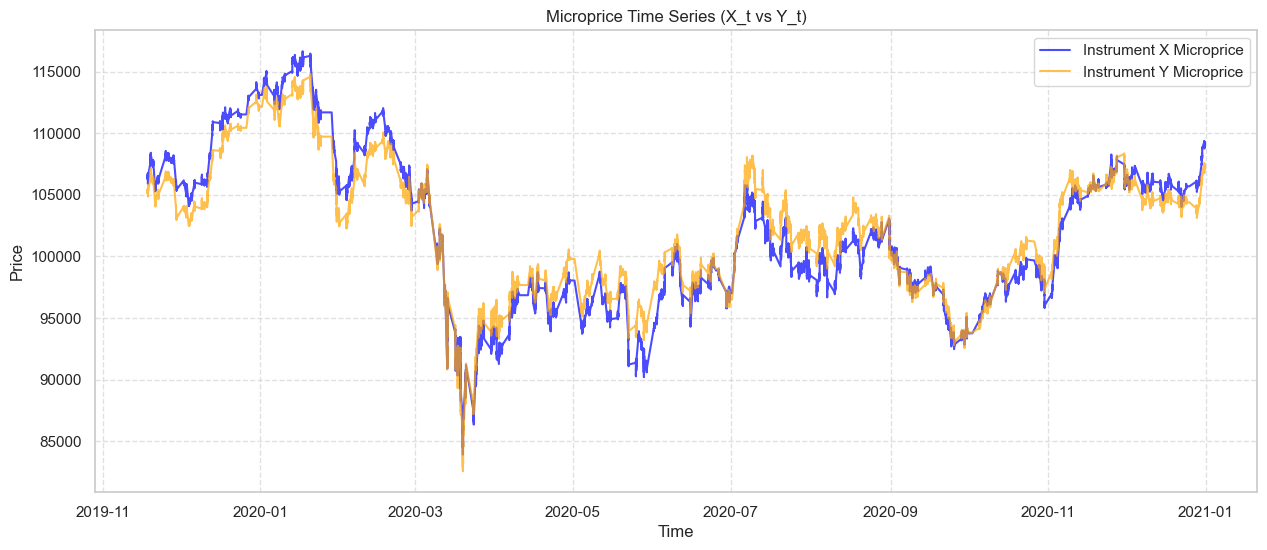

In [12]:
plt.figure(figsize=(15, 6))

# Plotting X_t
plt.plot(new_df['Time'], new_df['X_t'], label='Instrument X Microprice', color='blue', alpha=0.7)

# Plotting Y_t (Optional)
plt.plot(new_df['Time'], new_df['Y_t'], label='Instrument Y Microprice', color='orange', alpha=0.7)

plt.title('Microprice Time Series (X_t vs Y_t)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Looking at the above plot, we can see a clear anomaly around March-April 2020, which coincides with the COVID-19 volatility shock in early 2020. Such periods highlight the importance of monitoring volatility dynamics, particularly in high frequency settings where regime shifts can materially impact trading strategies

**Volatility and Handling of Overnight Gaps**

For high frequency data that can especially be affected by the effects of shocks such as the pandemic, it would be wise to perform rolling volatility to observe phases of regime shifts. To perform rolling volatility, we would have to calculate the log returns of $X_t$ and $Y_t$. Log returns specifically allow us to be time additive. To see what this means let us analyse the following:

$$r_t = \log (P_t) - \log(P_{t-1})$$

The log operation allows us to transform usual multiplicative dynamics (if we use the usual formula $r_t = \frac{P_t - P_{t-1}}{P_{t-1}}$) into additive state updates, allows us to measure proportional prices changes and are scale invariant.
$$\sum r_t = \log(P_T/P_0)$$

Another thing we must keep in mind as well is that our data is not fully continuous, notice the market data is only available from 8am- 2pm, so we must be cautious with how we construct the rolling window standard deviation. Overnight gaps represent discrete information jumps and would distort intraday volatility estimates if included within rolling windows. Hence, we must seperate intraday returns and overnight returns. This is especially important for when we consider rolling statistics. 

Additionally, weekends (non-trading periods) were removed from the dataset. Including weekends introduces artificial distortions, as prices remain static while time continues to advance, leading to misleading estimates of volatility, correlation, and spread dynamics. In earlier iterations of the analysis, retaining weekend observations significantly biased the intraday statistics and correlation structure. Removing these periods ensures that all calculations reflect active trading intervals only and preserves the integrity of the time-series properties.

It was also noted that there were intraday gaps between 10 am and 11 am with no data. Hence, when computing rolling statistics and differences, it is best to perform these in blocks of 8-10 am and 11 am - 2pm. This is implemented below.

In [13]:
vol_df = new_df.copy()
vol_df = vol_df[vol_df['Time'].dt.dayofweek < 5] #remove weekends
vol_df['log_X'] = np.log(vol_df['X_t'])
vol_df['log_Y'] = np.log(vol_df['Y_t'])

vol_df['mid_X'] = (df['X_BID'] + df['X_ASK']) / 2
vol_df['mid_Y'] = (df['Y_BID'] + df['Y_ASK']) / 2

is_new_day = vol_df['Time'].dt.date != vol_df['Time'].shift(1).dt.date
#intraday gaps 10am to 11am:
GAP = pd.Timedelta('5min')
is_gap = (vol_df['Time'].diff() > GAP).fillna(True)

#starting a new block:
is_new_block = is_new_day | is_gap
vol_df['block_id'] = is_new_block.cumsum()

vol_df['ret_X'] = vol_df.groupby('block_id')['log_X'].diff()
vol_df['ret_Y'] = vol_df.groupby('block_id')['log_Y'].diff()

vol_df['ret_X_mid'] = vol_df.groupby('block_id')['mid_X'].diff()
vol_df['ret_Y_mid'] = vol_df.groupby('block_id')['mid_Y'].diff()

#Note, since we are computing the log return which includes the operation of a diff,
# we must exclude difference over a day, i.e between 2 pm yesterday and 8 am today.

window = 6 * 60
vol_df['date'] = vol_df['Time'].dt.date

vol_df['roll_vol_X'] = (vol_df.groupby('block_id')['ret_X']
                        .transform(lambda s: s.rolling(window, min_periods = window).std()))
#perform standard deviation calculation intraday to avoid incorrect inflation of volatility

vol_df['roll_vol_Y'] = (vol_df.groupby('block_id')['ret_Y']
                        .transform(lambda s: s.rolling(window, min_periods = window).std()))


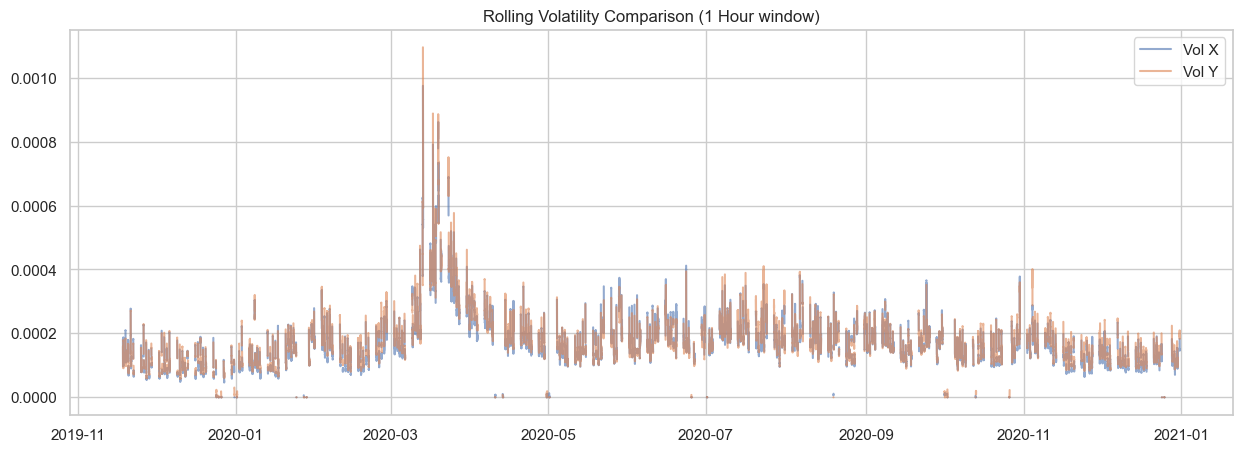

In [14]:
plt.figure(figsize=(15, 5))
plt.plot(vol_df['Time'], vol_df['roll_vol_X'], label='Vol X', alpha=0.6)
plt.plot(vol_df['Time'], vol_df['roll_vol_Y'], label='Vol Y', alpha=0.6)
plt.title("Rolling Volatility Comparison (1 Hour window)")
plt.legend()
plt.show()

We observe here that the period from 2020-04 to 2020-06 exhibits significantly elevated volatility, consistent with the COVID-19 market shock. Observation of these regime shifts are very important, as they may alter correlation structure, hedge ratios and liquidity conditions. It is therefore important to assess whether the relationship between X and Y remains stable accross voltility regimes and whether any trading signal is robust to these structural changes.

**Correlation**

We next examine the correlation between the two instruments. Since price levels are typically non-stationary and may share common trends, computing correlation on levels can lead to spurious results driven by shared drift rather than genuine co-movement.

To measure short-term comovement properly, we compute rolling correlation of log returns. Returns remove deterministic trends and capture proportional price changes, allowing us to assess whether the two instruments respond similarly to new information.

A persistently high rolling return correlation would suggest that the instruments are driven by common shocks, providing a foundation for further analysis of equilibrium relationships and potential relative value strategies.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


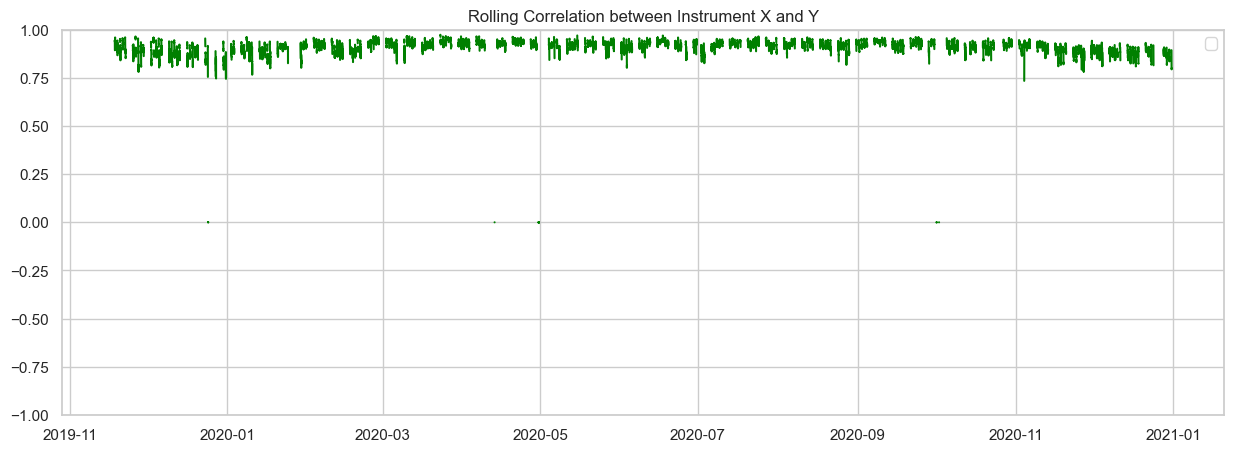

In [15]:
vol_df['roll_corr'] = (vol_df.groupby('block_id').apply(lambda g: g['ret_X'].rolling(window, min_periods = window).corr(g['ret_Y']))
.reset_index(level=0, drop = True)
                       )


plt.figure(figsize=(15, 5))
plt.plot(vol_df['Time'], vol_df['roll_corr'], color='green')
plt.title("Rolling Correlation between Instrument X and Y")
plt.ylim(-1, 1)
plt.legend()
plt.show()

In [16]:
low_corr = vol_df['roll_corr'].abs() < 0.5

vol_df['low_corr_flag'] = low_corr
vol_df['low_corr_block'] = (low_corr != low_corr.shift()).cumsum()

problem_periods = (
    vol_df[vol_df['low_corr_flag']]
    .groupby('low_corr_block')
    .agg(start=('Time','first'),
         end=('Time','last'),
         min_corr=('roll_corr','min'),
         count=('roll_corr','size'))
)

problem_periods

,start,end,min_corr,count
low_corr_block,,,,
2,2019-12-24 12:00:00,2019-12-24 13:25:50,-0.000445,516
4,2020-04-13 09:00:00,2020-04-13 09:11:20,0.000000,69
6,2020-04-30 09:00:00,2020-04-30 09:02:20,0.000000,15
8,2020-04-30 09:30:10,2020-04-30 09:38:40,-0.000927,52
10,2020-04-30 12:40:50,2020-04-30 12:54:20,-0.000839,82
12,2020-04-30 13:02:00,2020-04-30 14:00:00,0.000000,349
14,2020-10-01 09:00:00,2020-10-01 10:00:00,-0.000368,361
16,2020-10-01 12:41:20,2020-10-01 13:43:40,-0.000517,375
18,2020-10-02 09:42:30,2020-10-02 10:00:00,0.000000,106


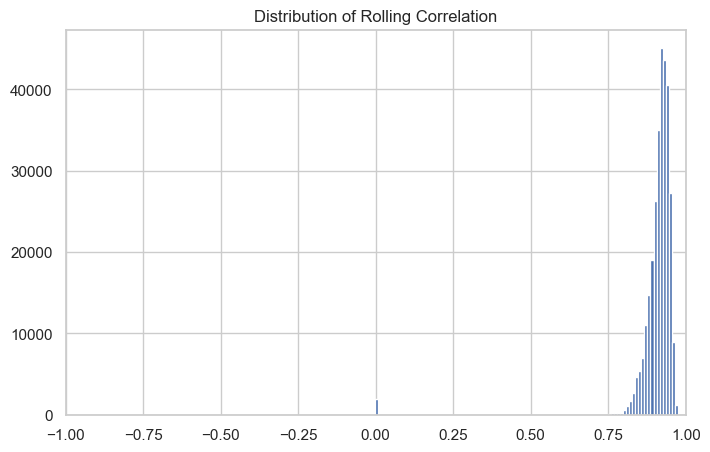

In [17]:
plt.figure(figsize=(8,5))
plt.hist(vol_df['roll_corr'].dropna(), bins=100)
plt.xlim(-1, 1)
plt.title("Distribution of Rolling Correlation")
plt.show()

In [18]:
vol_df['roll_corr'].describe()

count    298581.000000
mean          0.908033
std           0.079229
min          -0.000927
25%           0.897919
50%           0.919560
75%           0.935873
max           0.974174
Name: roll_corr, dtype: float64

In [19]:
vol_df['roll_corr'].quantile([0.01, 0.05, 0.95, 0.99])

0.01    0.800298
0.05    0.850100
0.95    0.951987
0.99    0.960858
Name: roll_corr, dtype: float64

Note we have a rolling window size of 360, which corresponds to 1 hour. The reason why a rolling window of size of 360 was chosen was because this allows us to be able to see notable regions where the correlation between the returns changes significantly. Notice from the above plots, for the majority of the days, we observe a strong positive correlation between the returns of the instruments, around 0.919. 


The rolling return correlation is persistently high throughout the sample. The median correlation is 0.919, with 75% of observations above 0.898. This indicates a structurally strong short-run comovement between X and Y.

The mean correlation (0.908) is slightly lower than the median due to rare collapse episodes, including extreme near zero values. However, these events occur infrequently (below the 1st percentile).

Overall, the distribution suggests that the instruments are tightly linked in the majority of trading periods.

**Cointegration**

While correlation confirms strong short-run comovement, it does not guarantee a stable long-run equilibrium in price levels. We therefore next examine whether a stationary linear combination exists. Particularly, in pairs trading, we rely on the spread between the prices of the 2 instruments X and Y to exhibit a property known as mean reversion. Formally, we write that the spread between the prices is stationary:
$$S_t = P_X - \beta P_Y = I(0)$$

So let us now perform a test for cointegration. To do this, we first construct a regression problem:
$$X_t = \alpha_1 + \beta_1 Y_t + \varepsilon_t$$
$$Y_t = \alpha_2 + \beta_2 X_t + \varepsilon_t$$
Note, we consider 2 regression problems due to the asymmetry of OLS. This point will be further elaborated below.


In [20]:
X = sm.add_constant(vol_df['Y_t'])
model = sm.OLS(vol_df['X_t'], X).fit()

beta_1 = model.params[1]
alpha_1 = model.params[0]

print(beta_1)
print(alpha_1)
print(model.summary())

1.1407882676429169
-14566.797228551435
                            OLS Regression Results                            
Dep. Variable:                    X_t   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                 1.183e+07
Date:                Sun, 15 Feb 2026   Prob (F-statistic):               0.00
Time:                        21:35:32   Log-Likelihood:            -4.5399e+06
No. Observations:              528533   AIC:                         9.080e+06
Df Residuals:                  528531   BIC:                         9.080e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1

In [21]:
Y = sm.add_constant(vol_df['X_t'])
model2 = sm.OLS(vol_df['Y_t'], Y).fit()

beta_2 = model2.params[1]
alpha_2 = model2.params[0]

print("beta2 (Y on X):", beta_2)
print("alpha2:", alpha_2)
print(model2.summary())

beta2 (Y on X): 0.8390925760734573
alpha2: 16588.46697144818
                            OLS Regression Results                            
Dep. Variable:                    Y_t   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                 1.183e+07
Date:                Sun, 15 Feb 2026   Prob (F-statistic):               0.00
Time:                        21:35:33   Log-Likelihood:            -4.4588e+06
No. Observations:              528533   AIC:                         8.918e+06
Df Residuals:                  528531   BIC:                         8.918e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

Let us now look into the spread.

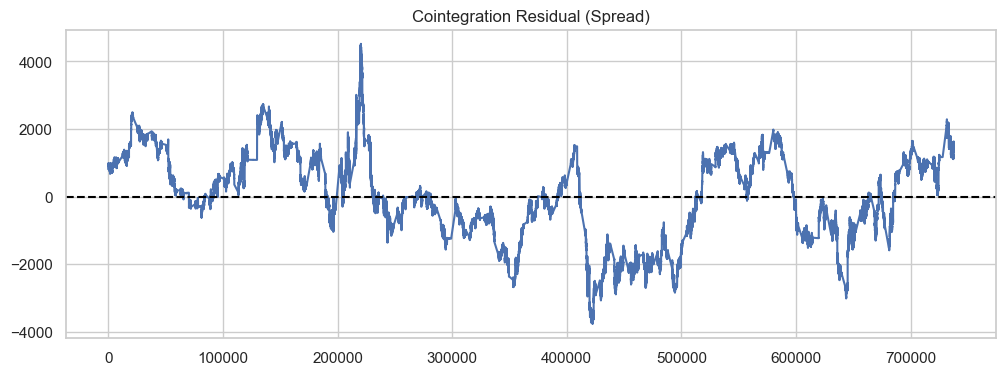

In [22]:
vol_df['spread_XonY'] = vol_df['X_t'] - (alpha_1 + beta_1 * vol_df['Y_t'])

plt.figure(figsize=(12,4))
plt.plot(vol_df['spread_XonY'])
plt.axhline(vol_df['spread_XonY'].mean(), color='black', linestyle='--')
plt.title("Cointegration Residual (Spread)")
plt.show()

**Stationarity as a preliminary step**

So how do we test that the spread above is stationary? To investigate this, lets show an example of analysing whether $X_t$ is stationary or not. We will first work with a simpler case, looking at an integrated process of order 1:
$$X_t = \mu + \phi X_{t-1} + \varepsilon_t$$
Additionally, we assume that $\varepsilon_t$ is a random variable with 0 mean and a constant finite variance. 
$$\forall t, \mathbb{E}(\varepsilon_t) = 0, \text{Var}(\varepsilon_t) = \sigma^2$$
Now we ask the question, what conditions make the above signal stationary? Lets recurse through the above equation, we can see that:
$$X_t = \mu + \phi^t X_0 + \sum_{k=0}^{t-1} \phi^k \epsilon_{t-k}$$
Notice:
$$\mathbb{E}(X_t) = \mu + \phi^t X_0 $$
$$\text{Var}(X_t) = \sigma^2 \sum_{k=0}^{t-1} \phi^{2k}$$
From the above, we can see that if $|\phi| < 1$:
$$\lim_{t \rightarrow \infty} \mathbb{E}(X_t) = \mu $$
$$\lim_{t \rightarrow \infty} \text{Var}(X_t) = \frac{\sigma^2}{1-\phi^2}$$
However, for $|\phi| = 1$:
$$\lim_{t \rightarrow \infty} \mathbb{E}(X_t) = \mu + X_0$$
$$\lim_{t \rightarrow \infty} \text{Var}(X_t) = \infty$$
The above case is known as the unit root, which leads to a non-stationary signal. The above 2 cases forms the argument for how the Dickey Fuller and ADF tests are formed. (Note, the case where $|\phi| > 1$ would lead to an exploding mean as $t \rightarrow \infty$ and is therefore non-stationary). Ultimately to test whether a signal is stationary, we adopt the null hypothesis that:
$$H_0: \phi = 1$$
And the alternate hypothesis:
$$H_1: |\phi| < 1$$
Let us now revist:
$$X_t = \mu + \phi X_{t-1} + \varepsilon_t$$
Consider:
$$X_t - X_{t-1} = \Delta X_t= \mu + (\phi - 1) X_{t-1} + \varepsilon_t$$
Under the null hypothesis that $\phi = 1$, we see that:
$$\Delta X_t= \mu + \varepsilon_t$$
Which means that $\Delta X_t$ is stationary. To test whether the signal is stationary, lets re-express, let $\delta = \phi -1$:
$$\Delta X_t= \mu + \delta X_{t-1} + \varepsilon_t$$
With the following hypotheses:
$$H_0: \delta = 0$$
$$H_1: \delta < 0$$
Hence, we can essentially perform OLS where the dependent variable is $\Delta X_t$ and the regressor is $X_{t-1}$. Once we perform the regression and retrieve the estimator $\hat{\delta}$, we perform a t-test:
$$t_\delta = \frac{\hat{\delta}}{SE(\hat{\delta})}$$
However, we do not compare this with the standard t- distribution as under the null hypothesis $X_{t-1}$ is non-stationary, so the limiting distribution of $\frac{\hat{delta}}{SE(\hat{\delta})}$ is actually the Dickey-Fuller distribution. Thus we would reject the null hypothesis when:
$$t_{\hat{\delta}} < DF_{critical}$$
The augmented Dickey-Fuller test is required for when we look at high order integrated processes:
$$X_t = \mu + \sum_{i=1}^P \phi_i X_{t-i} + \varepsilon_t $$
Let us rewrite this:
$$X_t - X_{t-1} = \Delta X_t = \mu + (\phi_1 - 1)X_{t-1} + \sum_{i=2}^P \phi_i X_{t-i} + \varepsilon_t $$
Now, let $\delta = \phi_1 -1 $ and $\beta_i$ be some real numbers s.t. $\sum_{i=1}^P \beta_i \Delta X_{t-i} = \sum_{i=2}^P \phi_i X_{t-i}$
$$ \Delta X_t = \mu + \delta X_{t-1} + \sum_{i=1}^P \beta_i \Delta X_{t-i} + \varepsilon_t  $$
And then we essentially perform the same idea as above. Note the value $P$ tells us the lag value, which is very important to consider later on

So, lets use the ADF test to observe that X and Y are non-stationary:

In [23]:
adf_X = adfuller(vol_df['X_t'], regression='c', maxlag=5, autolag='AIC')
adf_Y = adfuller(vol_df['Y_t'], regression='c', maxlag=5, autolag='AIC')

print("X ADF:", adf_X[0], "p:", adf_X[1])
print("Y ADF:", adf_Y[0], "p:", adf_Y[1])

X ADF: -1.805157238462105 p: 0.37790429065663594
Y ADF: -2.2536773543912494 p: 0.18734321906214585


**Formulating a test for Cointegration via Stationarity and ADF**

Observing the above results, the p-value represents, under the null hypothesis of a unit root, the probability of obtaining a test statistic at least as extreme as the one observed. For both $X_t$ and $Y_t$, the p-values (0.375 and 0.182 respectively) are greater than conventional significance levels such as 5%. Therefore, we fail to reject the null hypothesis that the series contains a unit root. This indicates that the log-price series, and thus price series are non-stationary in levels. So, now lets test cointegration between $X_t$ and $Y_t$. The idea now is since we have already performed the regression of $$X_t = \alpha_1 + \beta_1 Y_t + \varepsilon_t$$

So, from the above derivations, the process to test whether $X_t$ and $Y_t$ are cointegrated is to look at the spread between the 2 instruments and then apply ADF to test whether it is stationary. Now, let us revisit as to why we had to perform OLS twice for the Spread of X on Y and the Spread of Y on X:
$$X_t = \alpha_1 + \beta_1 Y_t + \varepsilon_t$$
$$Y_t = \alpha_2 + \beta_2 X_t + \varepsilon_t$$
Recall that OLS is not symmetric and so the above spreads would yield different estimates of the cointegrating coefficient nd therefore different spread series. 

This asymmetry arises because ordinary least squares (OLS) minimizes the sum of squared errors in the dependent variable only. When we regress  
$$X_t = \alpha_1 + \beta_1 Y_t + \varepsilon_t$$

we are minimizing deviations in $X_t$. When we reverse the regression, we instead minimize deviations in $Y_t$.

Since cointegration concerns the existence of any stationary linear combination of the two non-stationary series, the choice of dependent variable can influence the estimated spread and its stationarity properties.

Therefore, we will estimate the regression in both directions and apply the Augmented Dickey–Fuller (ADF) test to each resulting residual series. The specification that provides stronger evidence of stationarity—indicated by a more negative ADF test statistic (or equivalently, a smaller p-value)—is selected as the preferred cointegrating relationship. The corresponding coefficient is then used to define the spread.

**Autocorrelation Analysis for identification of Integrated process order (ADF Testing)**

So lets revisit the construction:
$$ \Delta X_t = \mu + \delta X_{t-1} + \sum_{i=1}^P \beta_i \Delta X_{t-i} + \varepsilon_t  $$

We must now determine an appropriate value for $P$ so that the ADF regression properly captures the short-run dynamics of the spread while preserving valid statistical inference. The parameter $P$ denotes the number of lagged differences $\Delta X_{t-i}$ included in the regression to account for potential serial correlation in the error term. Including these lags ensures that the residuals of the ADF regression behave approximately as white noise, satisfying our assumption that:
$$\mathbb{E}(\varepsilon_t) = 0, \text{Var}(\varepsilon_t) = \sigma^2$$

To inform this choice, we examine the autocorrelation function (ACF) and partial autocorrelation function (PACF) of the first-differenced spread. The ACF measures the correlation between a series and its past values at different lags, providing insight into the persistence of shocks over time. The PACF, on the other hand, measures the direct correlation between the series and a particular lag after controlling for the influence of intermediate lags. While the ACF reflects overall dependence across time, the PACF helps identify the effective order of autoregressive structure.

If the ACF decays quickly and becomes negligible after only a few lags, this indicates short memory in the process and suggests that a small value of $P$ is sufficient. Conversely, a slow decay would imply more persistent dynamics and the need for additional lag terms.



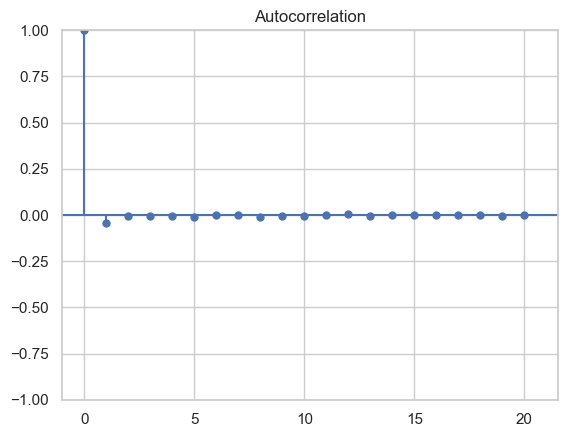

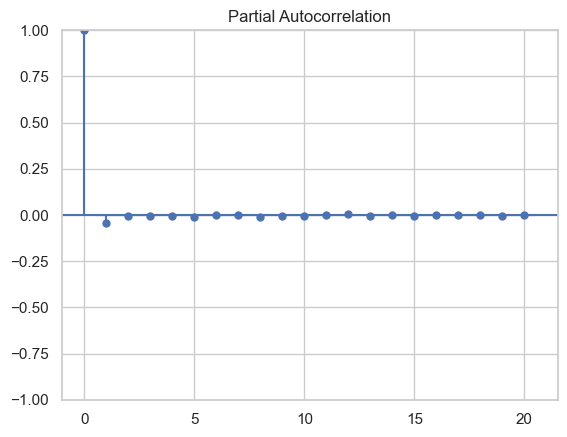

In [24]:
ds = vol_df['spread_XonY'].diff().dropna()

plot_acf(ds, lags=20)
plt.show()

plot_pacf(ds, lags=20, method="ywm")
plt.show()

The autocorrelation (ACF) and partial autocorrelation (PACF) plots of the first-differenced spread indicate very limited serial dependence. Apart from the trivial spike at lag 0, the autocorrelations at subsequent lags are small in magnitude and decay rapidly toward zero. There is no evidence of a slow, persistent decay pattern that would suggest long memory in the process. Similarly, the PACF does not display any significant spikes beyond the first few lags, indicating the absence of a higher-order autoregressive structure.

This rapid decay implies that the short-run dynamics of the differenced spread are captured within only a few lags. Consequently, setting the maximum lag length to $P = 5$ in the ADF regression is sufficient to account for any minor residual autocorrelation while avoiding overfitting. Allowing up to five lagged differences provides a conservative upper bound that ensures the regression errors approximate white noise without unnecessarily increasing model complexity.

An interesting note from the above plots is that the spread exhibits a random-walk-like behaviour, where changes in the spread are essentially unpredictable from past changes. This observation has important implications for parameter estimation: if the spread follows a random walk with Gaussian innovations (as confirmed by our earlier normality tests), then traditional static estimation methods like rolling-window OLS may be suboptimal.

**Implications for Hedge Ratio Estimation:**

The random walk property suggests that the hedge ratio (beta) itself may not be constant over time, but rather evolves stochastically. A rolling window approach implicitly assumes beta remains fixed within each window, which contradicts the continuous evolution implied by random walk dynamics. Furthermore, rolling windows introduce artificial discontinuities when the window shifts and suffer from a fundamental trade-off: wider windows improve statistical precision but reduce responsiveness to genuine parameter changes, while narrower windows adapt quickly but increase estimation noise.

Given that:
1. The spread follows a random walk with Gaussian noise (ACF ≈ 0, normally distributed innovations)
2. We require time-varying parameter estimates that update continuously
3. We need to balance responsiveness with statistical efficiency

This motivates the use of **state-space methods** for adaptive parameter estimation. Specifically, the Kalman filter provides an optimal framework for estimating time-varying regression coefficients when:
- The state (hedge ratio) evolves as a random walk: $\beta_t = \beta_{t-1} + w_t$
- Observations follow a linear model with Gaussian noise: $Y_t = \alpha_t + \beta_t X_t + v_t$
- Both process noise $w_t$ and measurement noise $v_t$ are normally distributed

The Kalman filter recursively updates parameter estimates with each new observation, weighting new information against prior estimates according to their relative uncertainties. This provides:
- Smooth, continuous parameter evolution (no window discontinuities)
- Optimal estimates under Gaussian assumptions (proven by the Kalman-Bucy theorem)
- Uncertainty quantification through the state covariance matrix
- Computational efficiency (O(n) vs O(nw) for rolling windows)

In the following section, we implement Kalman filtering for pairs trading, using the empirical variance from our return distributions to initialize the observation noise parameter and allowing the process noise to govern the speed of beta adaptation.


In [25]:
adf = adfuller(vol_df['spread_XonY'].values, regression="n", autolag="AIC", maxlag=5)

print("ADF stat:", adf[0])
print("p-value:", adf[1])
print("used lag:", adf[2])
print("nobs:", adf[3])
print("crit vals:", adf[4])

ADF stat: -3.1157293544336078
p-value: 0.00182581388871957
used lag: 5
nobs: 528527
crit vals: {'1%': -2.5657442302604454, '5%': -1.9410005082169248, '10%': -1.6168194974809895}


In [26]:
vol_df['spread_YonX'] = vol_df['Y_t'] - (alpha_2 + beta_2 * vol_df['X_t'])

adf = adfuller(vol_df['spread_YonX'].values, regression="n", autolag="AIC", maxlag=10)

print("ADF stat:", adf[0])
print("p-value:", adf[1])
print("used lag:", adf[2])
print("nobs:", adf[3])
print("crit vals:", adf[4])

ADF stat: -3.3383111360221274
p-value: 0.000857468947787237
used lag: 10
nobs: 528522
crit vals: {'1%': -2.5657442303004654, '5%': -1.941000508221733, '10%': -1.6168194974762355}


When comparing the two residual-based ADF tests, the spread obtained from regressing $Y_t$ on $X_t$ produces a more negative test statistic and a smaller p-value. We therefore adopt this specification, as it provides stronger evidence of residual stationarity. However, it is important to distinguish this comparison from the formal `coint()` implementation, which applies MacKinnon-adjusted critical values that account for the generated-regressor nature of the residual. While the residual ADF comparison guides our choice of hedge ratio ($\beta$), the formal cointegration inference should be based on the Engle–Granger test statistic. 


Accordingly, we define the spread as:

$$
S_t = Y_t - (\alpha_2 + \beta_2 X_t)
$$

Using the estimated coefficients:

$$
\beta_2 = 0.839, \qquad
\alpha_2 = 16590.83
$$

so that

$$
S_t = Y_t - (16590.83 + 0.839 X_t).
$$


In [27]:
coint_t, pvalue, crit_vals = coint(
    vol_df['X_t'],
    vol_df['Y_t'],
    trend='c',
    maxlag=5,
    autolag= 'AIC'
)

print("Cointegration test statistic:", coint_t)
print("p-value:", pvalue)
print("critical values:", crit_vals)

Cointegration test statistic: -3.115729354439604
p-value: 0.08518708594748753
critical values: [-3.89646072 -3.33614156 -3.04445802]


The Engle–Granger cointegration test yields a test statistic of -3.116 with a corresponding p-value of 0.0851. Comparing this value to the MacKinnon-adjusted critical values, we observe that the statistic does not exceed the 5% critical threshold (-3.336), but it does exceed the 10% critical value (-3.044). Therefore, we fail to reject the null hypothesis of no cointegration at the 5% significance level, but reject it at the 10% level. 

This indicates moderate evidence of a long-run equilibrium relationship between the two instruments. While the residual-based ADF tests suggested strong stationarity using standard Dickey–Fuller critical values, the formally adjusted Engle–Granger test provides a more conservative assessment. Consequently, the evidence for cointegration is present but not overwhelmingly strong, and any pairs trading strategy based on this relationship should be evaluated carefully for robustness. 

Talk about the ACF plot for auto correlation, its possible that we are actually looking at a random walk, so be careful

**Periodic Patterns**

To formulate a concrete trading strategy, let us observe some periodic patterns:

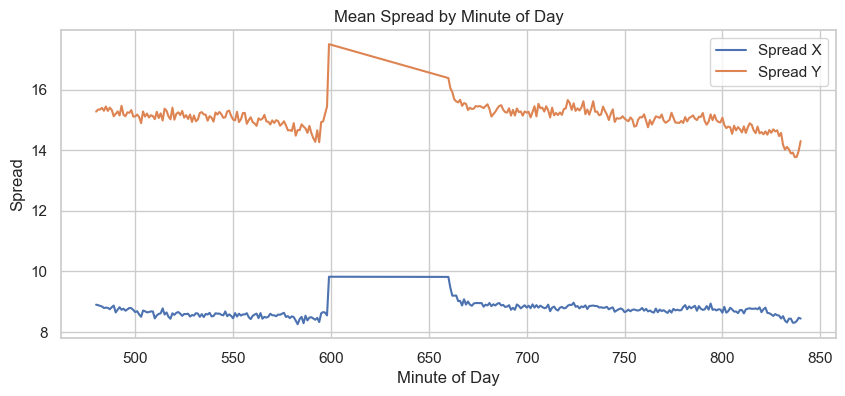

In [28]:
vol_df['hour'] = vol_df['Time'].dt.hour
vol_df['minute_of_day'] = 60 * vol_df['hour'] +  vol_df['Time'].dt.minute

vol_df_clean = vol_df[~vol_df['hour'].between(10, 10)]

#Intraday spread seasonality:
spread_intraday_X = vol_df_clean.groupby('minute_of_day')['X_spread'].mean() #check this, could be outliers
spread_intraday_Y = vol_df_clean.groupby('minute_of_day')['Y_spread'].mean()
plt.figure(figsize=(10,4))

plt.plot(spread_intraday_X, label='Spread X')
plt.plot(spread_intraday_Y, label='Spread Y')

plt.title("Mean Spread by Minute of Day")
plt.xlabel("Minute of Day")
plt.ylabel("Spread")
plt.legend()
plt.show()

In [29]:
spread_intraday_Y.loc[595:665]

minute_of_day
595    14.926304
596    14.948980
597    15.198413
598    15.442177
599    17.500000
660    16.381279
661    16.050228
662    15.918950
663    15.679224
664    15.610731
665    15.576484
Name: Y_spread, dtype: float64

The results here are extremely interesting, when analysing the spread, it seems that the median spread of instrument X stays at around $8 before the 600th minute of the day (corresponding to 10 am) to which it jumps to a spread of around $16, and it decreases linearly back to a spread of 8 at the 660th minute (corresponding to 11 am). Instrument Y exhibits a structurally wider bid-ask spread throughout the session, indicating lower liquidity relative to X. It also exhibits the same behaviour where it jumps from a spread of $10 to $30 at 10 am and linearly decreases back down to $10 at 11 am where it stays constant. Note, the median has been used here to be robust to outliers. 

To gain thoughtful insights to this, it is best to understand the mechanics that we rely on to make a profit in pairs trading. We essentially identify a relative mispricing between two instuments. 

$$S_t = Y_t - (\alpha + \beta X_t)$$

Our edge comes from:
$$\mathbb{E}(S_{t+1} - S_t | S_t) < 0$$
When $S_t$ is high (implying we expect the spread in the next time to lower), and:
$$\mathbb{E}(S_{t+1} - S_t |S_t) > 0$$
When $S_t$ is low (implying we expect that the spread in the next time will increase).
This is the essence of mean reversion, the deviations are expected to revert. 

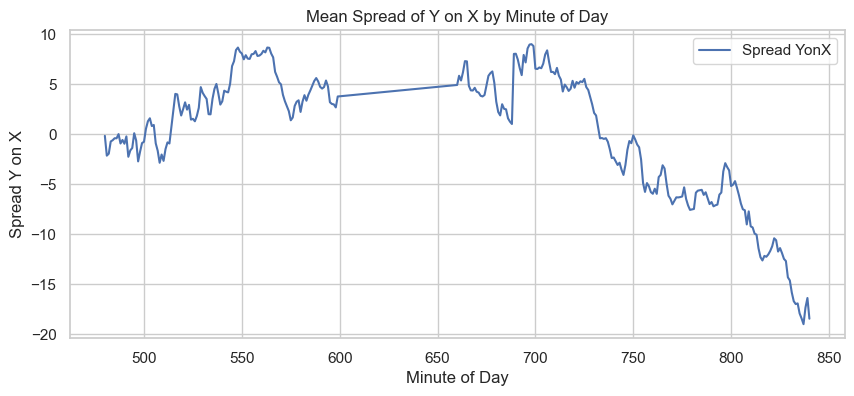

In [30]:
#Intraday spread seasonality:
spread_YonX = vol_df_clean.groupby('minute_of_day')['spread_YonX'].mean() #check this, could be outliers
#spread_intraday_Y = vol_df.groupby('minute_of_day')['Y_spread'].median()
plt.figure(figsize=(10,4))

plt.plot(spread_YonX, label='Spread YonX')
#plt.plot(spread_intraday_Y, label='Spread Y')

plt.title("Mean Spread of Y on X by Minute of Day")
plt.xlabel("Minute of Day")
plt.ylabel("Spread Y on X")
plt.legend()
plt.show()

There is again a stable relationship found between 10 am and 11 am of each day, here we see that the spread of the instrument Y on X linearly increases during this period. 

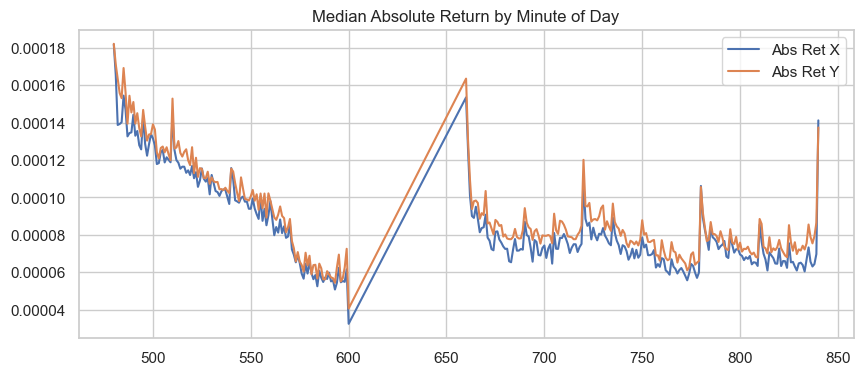

In [31]:
vol_df['abs_ret_X'] = vol_df['ret_X'].abs()
vol_df['abs_ret_Y'] = vol_df['ret_Y'].abs()

vol_intraday_X = vol_df.groupby('minute_of_day')['abs_ret_X'].median()
vol_intraday_Y = vol_df.groupby('minute_of_day')['abs_ret_Y'].median()

plt.figure(figsize=(10,4))
plt.plot(vol_intraday_X, label='Abs Ret X')
plt.plot(vol_intraday_Y, label='Abs Ret Y')
plt.title("Median Absolute Return by Minute of Day")
plt.legend()
plt.show()

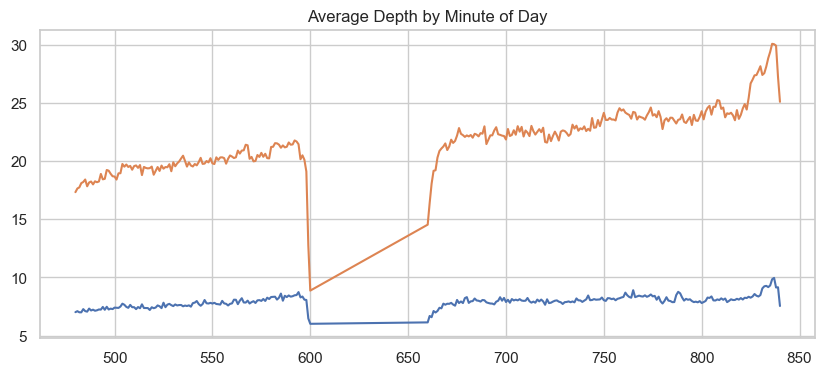

In [32]:
vol_df['depth_X'] = df['X_BID_VOL'] + df['X_ASK_VOL']
vol_df['depth_Y'] = df['Y_BID_VOL'] + df['Y_ASK_VOL']

depth_intraday_X = vol_df.groupby('minute_of_day')['depth_X'].mean()
depth_intraday_Y = vol_df.groupby('minute_of_day')['depth_Y'].mean()

plt.figure(figsize=(10,4))
plt.plot(depth_intraday_X, label='Depth X')
plt.plot(depth_intraday_Y, label='Depth Y')
plt.title("Average Depth by Minute of Day")
plt.show()

In [33]:
vol_df['weekday'] = vol_df['Time'].dt.weekday

vol_df.groupby('weekday')['abs_ret_X'].mean()
vol_df.groupby('weekday')['X_spread'].mean()
vol_df.groupby('weekday')['roll_corr'].mean()

summary_table = (
    vol_df
    .groupby('weekday')
    .agg(
        mean_abs_ret_X=('abs_ret_X', 'mean'),
        mean_X_spread=('X_spread', 'mean'),
        mean_roll_corr=('roll_corr', 'mean')
    )
    .reset_index()
)

summary_table


,weekday,mean_abs_ret_X,mean_X_spread,mean_roll_corr
0,0,0.000126,8.002107,0.914013
1,1,0.000121,9.019169,0.904594
2,2,0.000121,8.153753,0.914230
3,3,0.000126,8.954265,0.896348
4,4,0.000123,9.425160,0.910919


In [34]:
vol_df.groupby('minute_of_day')['roll_corr'].median().loc[600]

0.9101921397027779

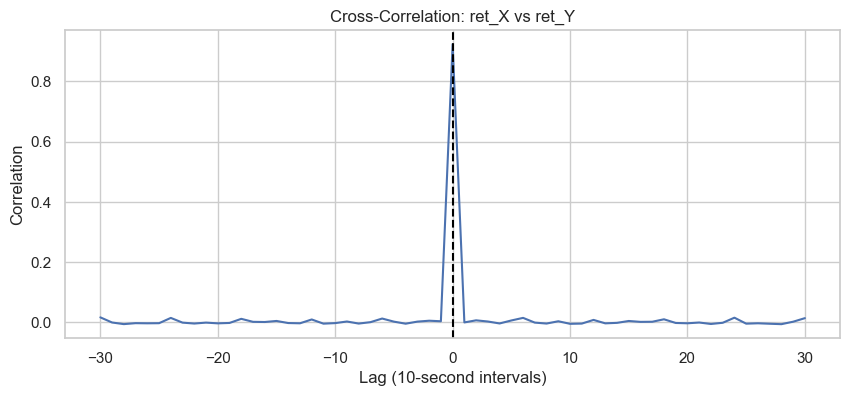

In [35]:
max_lag = 30  # 30 * 10s = 5 minutes
lags = range(-max_lag, max_lag+1)

cross_corr = []

for lag in lags:
    corr = vol_df['ret_X'].corr(vol_df['ret_Y'].shift(lag))
    cross_corr.append(corr)

plt.figure(figsize=(10,4))
plt.plot(lags, cross_corr)
plt.axvline(0, color='black', linestyle='--')
plt.title("Cross-Correlation: ret_X vs ret_Y")
plt.xlabel("Lag (10-second intervals)")
plt.ylabel("Correlation")
plt.show()

In [36]:
from statsmodels.regression.rolling import RollingOLS

rolling_window = 10 * 1800

roll_df = vol_df.copy()

X = sm.add_constant(roll_df['X_t'])
y = roll_df['Y_t']

rolling_model = RollingOLS(y, X, window=rolling_window)
rolling_res = rolling_model.fit()

rolling_params = rolling_res.params
roll_df['alpha_t'] = rolling_res.params['const']
roll_df['beta_t'] = rolling_res.params['X_t']

# Calculate spread
roll_df['S_t'] = roll_df['Y_t'] - (roll_df['alpha_t'] + roll_df['beta_t'] * roll_df['X_t'])
print(rolling_params)

               const       X_t
0                NaN       NaN
1                NaN       NaN
2                NaN       NaN
3                NaN       NaN
4                NaN       NaN
...              ...       ...
737734  27511.421100  0.728347
737735  27508.823171  0.728371
737736  27505.945413  0.728398
737737  27502.769675  0.728428
737738  27499.219576  0.728461

[528533 rows x 2 columns]


In [37]:
x = rolling_params['X_t'].dropna()
t = np.arange(len(x))

slope, intercept = np.polyfit(t, x.values, 1)

print("Drift slope:", slope)
print("Intercept:", intercept)

Drift slope: -2.5606956626913207e-07
Intercept: 1.0153785612663095


Drift slope is extremely low, so the rolling window is reasonable on this metric

In [38]:
spread = roll_df['Y_t'] - (rolling_params['const'] + rolling_params['X_t'] * roll_df['X_t'])

In [39]:
print(spread)

0                NaN
1                NaN
2                NaN
3                NaN
4                NaN
             ...    
737734    202.040810
737735    178.060435
737736    197.270714
737737    224.064951
737738    241.231231
Length: 528533, dtype: float64


In [40]:
rolling_mean = spread.rolling(rolling_window).mean()
rolling_std = spread.rolling(rolling_window).std()
z_score = (spread - rolling_mean) / rolling_std
roll_df['z_t'] = z_score
print(z_score)

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
            ...   
737734    0.608541
737735    0.547787
737736    0.596426
737737    0.664269
737738    0.707724
Length: 528533, dtype: float64


In [41]:
dfp = pd.DataFrame({
        "ds_next": spread.diff().shift(-1),
        "z": z_score
    }).dropna()

X = sm.add_constant(dfp["z"])
y = dfp["ds_next"]
fit = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": 30})
b = float(fit.params["z"])
t = float(fit.tvalues["z"])
r2 = float(fit.rsquared)

print(
    f"b: {b:.6f} | "
    f"t_hac: {t:.2f} | "
    f"R²: {r2:.6f} | "
    f"N: {int(fit.nobs):,}"
)


b: -0.065936 | t_hac: -5.93 | R²: 0.000054 | N: 492,534


In [42]:
spread_data = pd.DataFrame({'spread': spread,
                            'rolling mean' : rolling_mean,
                            'rolling std' : rolling_std,
                            'z score' : z_score},
                           index = roll_df.index)

print(spread_data)

            spread  rolling mean  rolling std   z score
0              NaN           NaN          NaN       NaN
1              NaN           NaN          NaN       NaN
2              NaN           NaN          NaN       NaN
3              NaN           NaN          NaN       NaN
4              NaN           NaN          NaN       NaN
...            ...           ...          ...       ...
737734  202.040810    -38.217056   394.809718  0.608541
737735  178.060435    -38.212278   394.811815  0.547787
737736  197.270714    -38.206958   394.814343  0.596426
737737  224.064951    -38.200326   394.817746  0.664269
737738  241.231231    -38.193293   394.821596  0.707724

[528533 rows x 4 columns]


<Figure size 2000x1000 with 0 Axes>

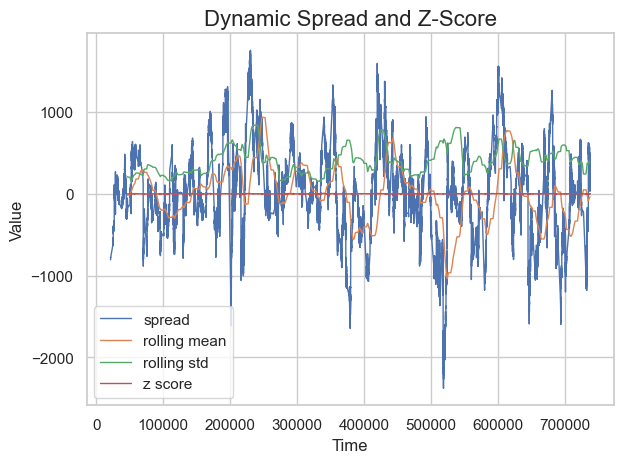

In [43]:
plt.figure(figsize=(20, 10))
spread_data.plot(linewidth=1)
plt.title("Dynamic Spread and Z-Score", fontsize=16)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

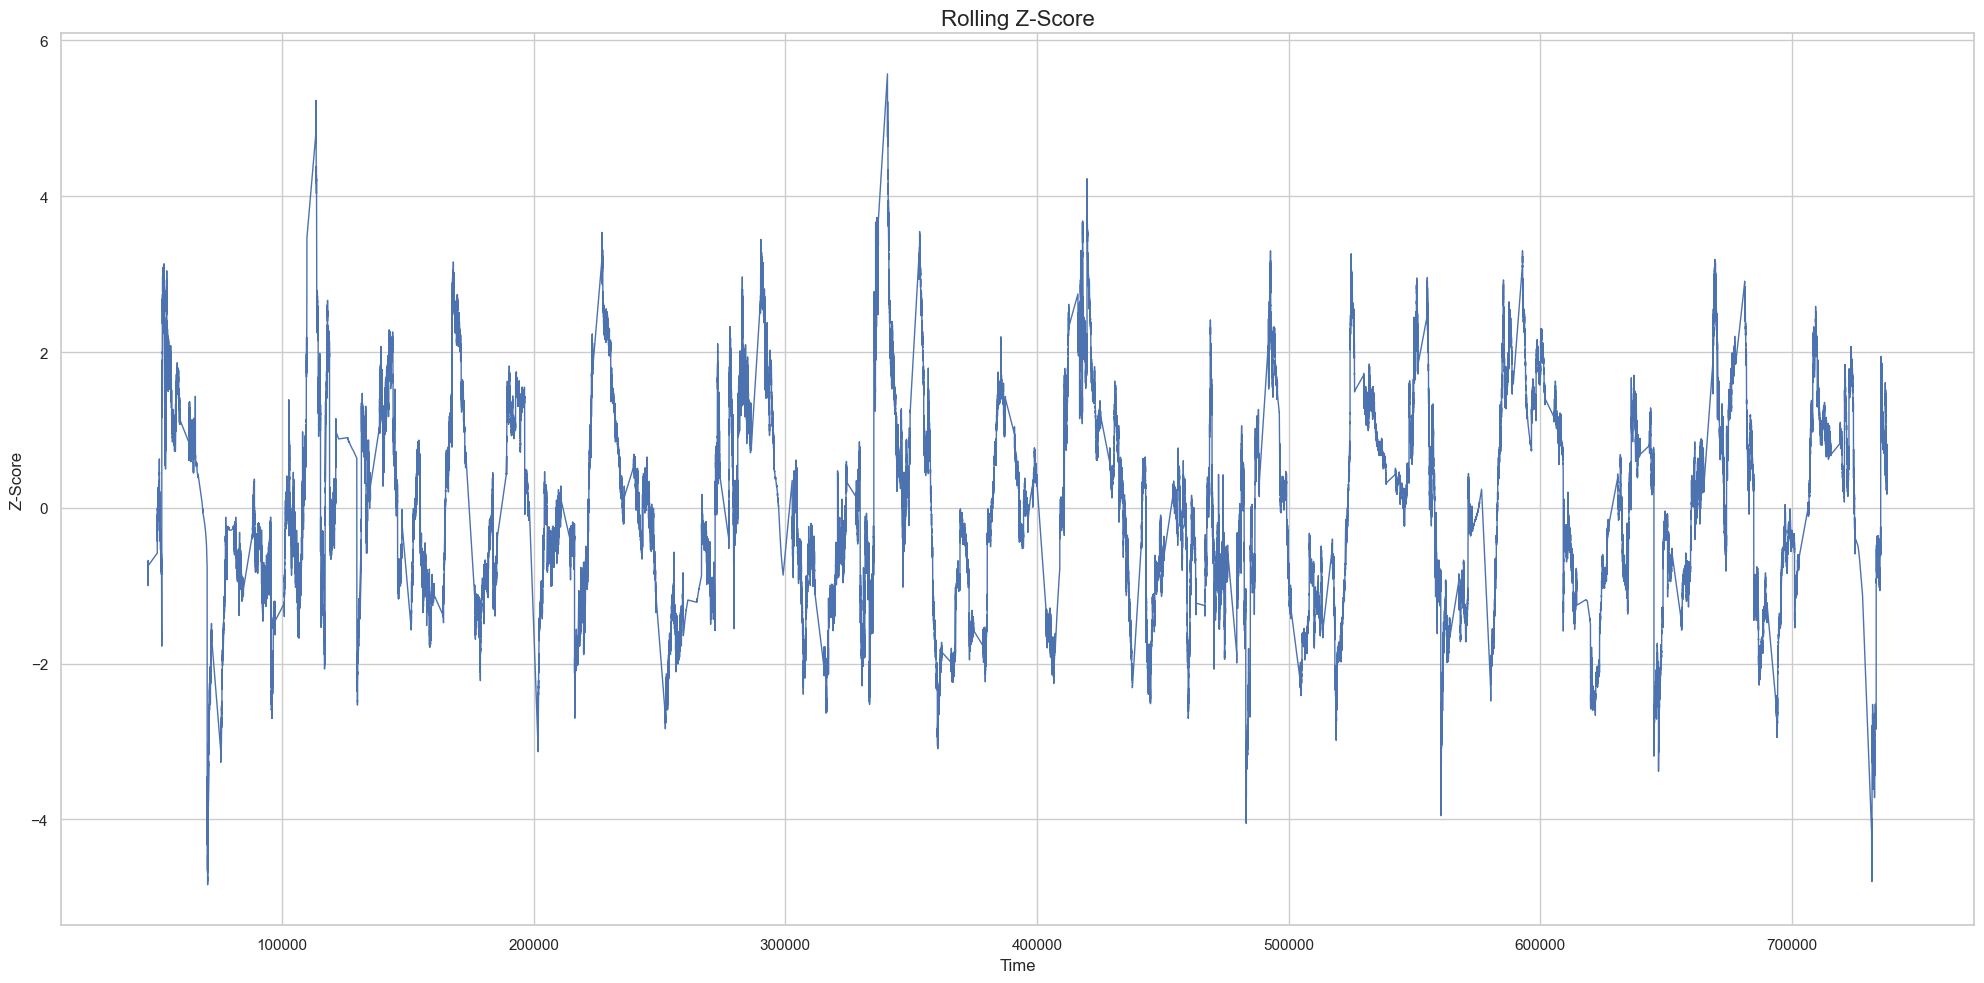

In [44]:
plt.figure(figsize=(20, 10))

spread_data['z score'].plot(linewidth=1)

plt.title("Rolling Z-Score", fontsize=16)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Z-Score", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

### Rolling Z-Score Analysis

The rolling z-score plot reveals several important characteristics of the spread dynamics:

**1. High Volatility in Z-Score**
The z-score exhibits substantial fluctuations, regularly crossing between ±2 and occasionally reaching extremes of ±5. This high volatility indicates:
- The spread experiences frequent deviations from its mean
- Entry signals ($|z_t| > z_{entry}$) occur regularly, providing ample trading opportunities
- But the noise also creates **false signals** where the spread appears mispriced but continues diverging before reverting

**2. Mean Reversion is Present but Noisy**
Despite the volatility, the z-score does exhibit mean-reverting behavior:
- Extreme values (|z| > 3) tend to be followed by returns toward zero
- The spread rarely sustains divergences beyond ±5 for extended periods
- However, the **speed of reversion is variable**—sometimes rapid (within hours), sometimes slow (across days)

**3. Clustered Volatility Patterns**
The z-score shows evidence of **volatility clustering**:
- Periods of high volatility (around observation 300,000 and 600,000) where z-scores swing wildly
- Periods of relative calm (around observation 450,000) where z-scores remain within ±1
- This suggests the spread relationship is **not stationary in variance**

**Implications for Trading Strategy:**

**Challenge 1: Signal Reliability**
The noisy z-score means not all signals are equally profitable:
- A z-score of +2.5 might revert immediately, or
- It might continue to +4 before reverting, causing unrealized losses
- This creates a **timing risk**: entering too early exposes us to further divergence

**Challenge 2: Threshold Selection**
The variability makes threshold selection critical:
- Too low ($z_{entry} = 1.5$): Many trades, but high false signal rate
- Too high ($z_{entry} = 3.0$): Fewer trades, but better signal quality
- Optimal threshold depends on transaction costs and risk tolerance

**Challenge 3: Regime Changes**
The clustered volatility suggests the spread relationship weakens periodically:
- During high-volatility periods, mean reversion is less reliable
- Risk management must adapt to current volatility regime
- Consider scaling position sizes inversely with recent z-score volatility

**Why This Noise is Expected:**

Financial markets are dominated by noise (as our OBI analysis confirmed):
- Even with cointegration, short-term price movements are unpredictable
- The z-score normalizes spread deviations, but cannot eliminate fundamental uncertainty
- **R² = 0.6%** from our OBI regression quantifies this: 99.4% of spread changes are unexplained by observable order flow

**Adaptive Response - Motivation for Kalman Filter:**

The variability in mean reversion speed and volatility clustering motivates our use of the Kalman filter:
1. **Time-varying parameters**: If noise levels change, the optimal $\beta$ estimate should adapt
2. **Uncertainty quantification**: Kalman filter provides $P_t$ (state variance), measuring confidence in current $\beta$ estimate
3. **Regime-aware trading**: When Kalman uncertainty ($P_t$) is high, reduce position size or widen entry thresholds

This noisy z-score pattern is **characteristic of real pairs trading opportunities**—perfectly clean mean reversion would be immediately arbitraged away. The challenge is extracting a positive expectation from this noisy process through:
- Robust parameter estimation (Kalman filter)
- Disciplined risk management (position sizing, stop-losses)
- Transaction cost awareness (enter only when edge exceeds costs)

$$S_t = Y_t - (\alpha_t + \beta_t X_t) $$
$$z_t = \frac{S_t - \mu_t}{\sigma_t}$$

The key strategy here is if $z_t > z_{enter}$ we perform a short spread where we short $Y$ and long $\beta X$, while if $z_t < -z_{enter}$, we perform a long spread where we long $Y$ and short $\beta X$. We would then exit when $|z_t| < z_{exit}$. The reason why we are look at the standard normal statistic $z_t$ is because it allows us to naturally perform a hypothesis test to evaluate whether the spread is likely to revert back assuming mean reversion as the null hypothesis. However, one component we have not yet fully analysed critically is the OBI:

**OBI**

$$OBI = \frac{BID_{VOL} - ASK_{VOL}}{BID_{VOL} + ASK_{VOL}}$$

The order book imbalance is a metric that allows us to measure the disparity between the total volume of buy orders and sell orders. Hence, a positive OBI signals a pressure in th buying side of an instrument. It is extremely important to use this to provide a better understanding to our trading decisions. Let us observe whether the OBI can provide strong signals to the spread.

To test this, lets perform the following regression:

$$\Delta S_{t+1} = \alpha + \beta_1 \text{OBI}_{X_t} + \beta_2 \text{OBI}_{Y_t}$$

The reason why we formulate the regression in this manner is that we are explicitly testing whether contemporaneous order flow pressure contains predictive information about the next time step's ($t+1$) change in spread. 


In [53]:
df2 = df.copy()

den_X = df2['X_BID_VOL'] + df2['X_ASK_VOL']
den_Y = df2['Y_BID_VOL'] + df2['Y_ASK_VOL']

df2['OBI_X'] = np.where(den_X != 0, (df2['X_BID_VOL'] - df2['X_ASK_VOL']) / den_X, np.nan)
df2['OBI_Y'] = np.where(den_Y != 0, (df2['Y_BID_VOL'] - df2['Y_ASK_VOL']) / den_Y, np.nan)

# Bring only the OBI columns into roll_df using index alignment
roll2 = roll_df.drop(columns=['OBI_X','OBI_Y'], errors='ignore') \
               .join(df2[['OBI_X','OBI_Y']], how='left')

roll2['OBI_pair'] = roll2['OBI_Y'] - roll2['beta_t'] * roll2['OBI_X']
roll2['delta_s']  = roll2['S_t'].diff().shift(-1)

# Prepare regression data: Δs_t+1 = a + b*OBI_X + c*OBI_Y + ε
reg = roll2[['delta_s', 'OBI_X', 'OBI_Y']].replace([np.inf, -np.inf], np.nan).dropna()

X = sm.add_constant(reg[['OBI_X', 'OBI_Y']])
y = reg['delta_s']
model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 10})

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                delta_s   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1619.
Date:                Sun, 15 Feb 2026   Prob (F-statistic):               0.00
Time:                        22:03:43   Log-Likelihood:            -1.9759e+06
No. Observations:              510533   AIC:                         3.952e+06
Df Residuals:                  510530   BIC:                         3.952e+06
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.015      0.084      0.9

The OBI analysis reveals a fundamental characteristic of high-frequency financial markets: statistically significant relationships can have minimal predictive power. With over 500,000 observations, even tiny effects become statistically significant (both p < 0.001), yet the model explains only 0.6% of variance. This demonstrates that price movements are overwhelmingly driven by noise rather than observable order flow.


**Overnight Gap Analysis**

for lag in range(-5, 6):
    corr = vol_df['ret_X'].corr(vol_df['ret_Y'].shift(lag))
    direction = "X leads Y" if lag > 0 else ("Y leads X" if lag < 0 else "contemporaneous")
    print(f"Lag {lag:+d}: {corr:.6f}  ({direction})")

- Look into cointegration, then link to hedge ratio, which links great into the bid-ask spread (transaction costs)

- Next steps, look at seasonal/ preriodic characteristics, use the argument of high correlation for cointegration, leading to the idea that the spread between X and Y are stationary.

- pricing relationships: we want to answer whether there is a stable exploitable pricing relation. Look at short run co-movement, long-run equilibrium, lead-lag effects, microstructure signals, predictability of spread reversion. (would be interesting to investigate lead lag structure)
- Right now, for
- Implement the Kalman Filter

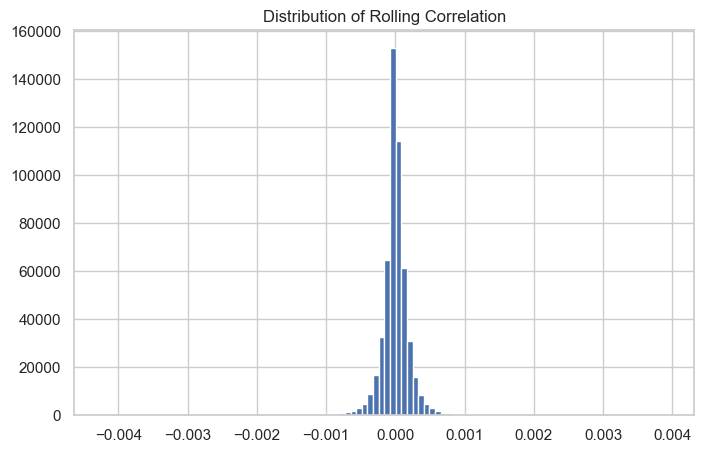

In [48]:
plt.figure(figsize=(8,5))
plt.hist(vol_df['ret_X'].dropna(), bins=100)
plt.title("Distribution of Rolling Correlation")
plt.show()

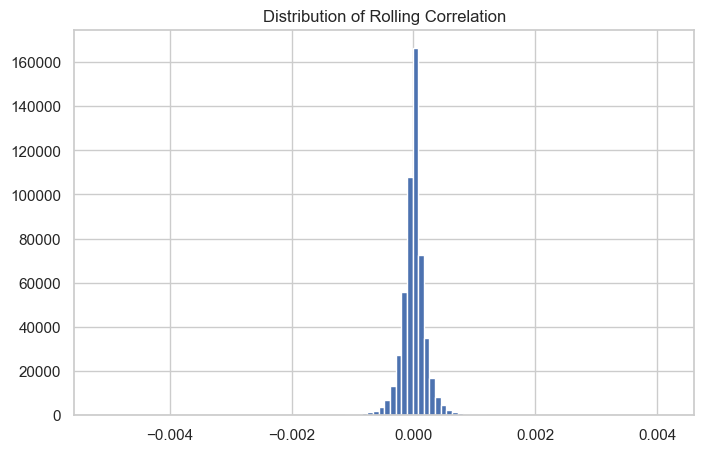

In [49]:
plt.figure(figsize=(8,5))
plt.hist(vol_df['ret_Y'].dropna(), bins=100)
plt.title("Distribution of Rolling Correlation")
plt.show()

**Regime Shift**

1. Use Kalman or rolling OLS, the beta value most like changes
2. Research into regime filters, particle filters, SSMs